In [ ]:
# Importing essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sqlalchemy
from pathlib import Path

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
np.set_printoptions(threshold=5) # Avoid printing out big matrices
%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## The IMDB (mini) Dataset


We will explore a miniature version of the [IMDb Dataset](https://www.imdb.com/interfaces/). This is the same dataset that we used for this week's lab.

Let's load in the database in two ways (using both Python and cell magic) so that we can flexibly explore the SQL database.

In [129]:
from pathlib import Path
import shutil
import pathlib

dbfile = 'imdbmini.db'

# Do not modify following lines.
# File structure on gradescope is slightly different from datahub, 
# hence we have to include this if-else statement to 
# make sure we can get the correct database
if Path('../../../../../../../gradescope').is_dir():
    tmpdb = Path('data') / dbfile 
else:
    # Staff note: File path if running from dist folder: "../../../../../../../tmp"
    # remove this in student version manually
    tmpdb = Path('../../../../../../../tmp') / dbfile 

if not tmpdb.is_file():
    print('Copying DB file to /tmp for faster access.')
    shutil.copy2(Path('data') / dbfile, tmpdb)
    
sqlite_conn = 'sqlite:///' + str(tmpdb)

In [130]:
# Run this cell to connect to database
engine = sqlalchemy.create_engine(sqlite_conn)
connection = engine.connect()

In [131]:
%sql {sqlite_conn}

<br/>

Let's take a look at the table schemas:

In [132]:
%%sql
-- just run this cell --
SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///../../../../../../../tmp/imdbmini.db
Done.


type,name,tbl_name,rootpage,sql
table,Title,Title,2,"CREATE TABLE ""Title"" (""tconst"" INTEGER, ""titleType"" TEXT, ""primaryTitle"" TEXT, ""originalTitle"" TEXT, ""isAdult"" TEXT, ""startYear"" TEXT, ""endYear"" TEXT, ""runtimeMinutes"" TEXT, ""genres"" TEXT)"
table,Name,Name,12,"CREATE TABLE ""Name"" (""nconst"" INTEGER, ""primaryName"" TEXT, ""birthYear"" TEXT, ""deathYear"" TEXT, ""primaryProfession"" TEXT)"
table,Role,Role,70,"CREATE TABLE ""Role"" (tconst INTEGER,ordering TEXT,nconst INTEGER,category TEXT,job TEXT,characters TEXT)"
table,Rating,Rating,41,"CREATE TABLE ""Rating"" (tconst INTEGER,averageRating TEXT,numVotes TEXT)"


<br/><br/>

---

### EDA
How far back does our data go? Does it only include recent data, or do we have information about older movies and movie stars as well? 
Let's find the 10 oldest movie titles and order them based on start year and title name in ascending order. 

In [133]:
query_q1a = """
SELECT startYear, primaryTitle, titleType FROM Title
WHERE startYear IS NOT NULL AND titleType IS 'movie'
ORDER BY startYear, primaryTitle
LIMIT 10;
"""


res_q1a = pd.read_sql(query_q1a, engine)
res_q1a

,startYear,primaryTitle,titleType
0,1915,The Birth of a Nation,movie
1,1920,The Cabinet of Dr. Caligari,movie
2,1921,The Kid,movie
3,1922,Nosferatu,movie
4,1924,Sherlock Jr.,movie
5,1925,Battleship Potemkin,movie
6,1925,The Gold Rush,movie
7,1926,The General,movie
8,1927,Metropolis,movie
9,1927,Sunrise,movie


<br/><br/>

---

### Movie Distributions

Technology and funding to make movies more or less accessible has changed over the past 100 years. Let's calculate the distribution of movies by year.



In [135]:
query_q1b = """
SELECT startYear, COUNT (*) AS total FROM Title
WHERE startYear IS NOT NULL AND titleType IS 'movie'
GROUP BY startYear
ORDER BY startYear ASC;
"""


res_q1b = pd.read_sql(query_q1b, engine)
res_q1b

,startYear,total
0,1915,1
1,1920,1
2,1921,1
3,1922,1
4,1924,1
...,...,...
97,2017,213
98,2018,230
99,2019,194
100,2020,117


<br/><br/>

Let's visualize this information and create bar plots for the number of movies created each year.

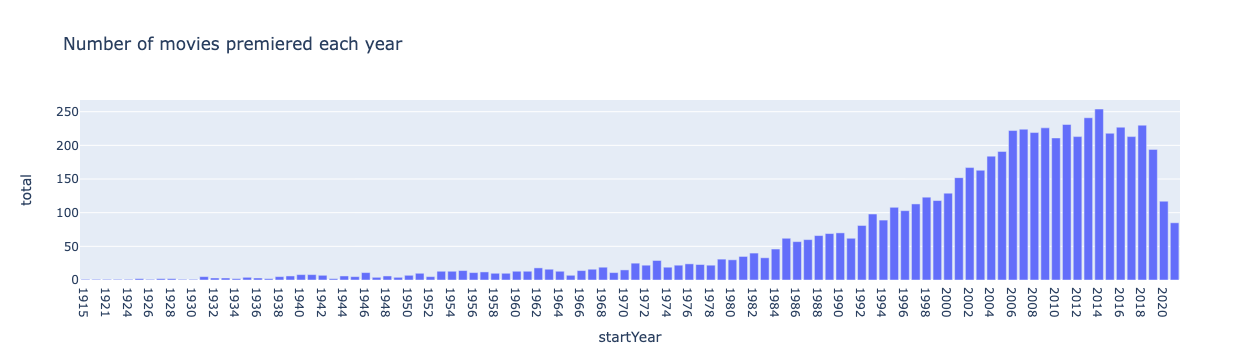

In [137]:
# Run this call to generate the bar plot.
px.bar(res_q1b, x="startYear", y="total", title="Number of movies premiered each year")

<br/><br/>

---

## Exploring Movie Actors

Let's deterine who are the top 10 most prolifict movie actors by calculating the number of movies an actor is in and list them in ascending order.

In [138]:
query_q2 = """
SELECT primaryName as name, COUNT(*) as total FROM Role 
JOIN Title ON Role.tconst = Title.tconst  
JOIN Name ON Role.nconst = Name.nconst
WHERE titleType IS 'movie' AND category IS 'actor' OR 'actress'
GROUP BY name
ORDER BY total DESC, name ASC
LIMIT 10;
"""

res_q2 = pd.read_sql(query_q2, engine)
res_q2

,name,total
0,Robert De Niro,64
1,Samuel L. Jackson,54
2,Nicolas Cage,53
3,Bruce Willis,49
4,Tom Hanks,46
5,Johnny Depp,43
6,Mark Wahlberg,41
7,Liam Neeson,40
8,Morgan Freeman,40
9,Adam Sandler,39


<br/><br/>

---

## Finding Big Hits Overtime

Not all movies are hits. Let's determine the proportion of movies that are hits and flops based on the number movies that get more than 100000 votes. 

In [140]:
query_q3 = """
SELECT COUNT(*) as total,
    CASE
        WHEN CAST(numVotes as int) > 100000 THEN 'yes'
        ELSE 'no'
    END AS isBigHit
FROM Rating

JOIN Title ON Rating.tconst = Title.tconst
WHERE titleType IS 'movie'
GROUP BY isBigHit;
"""


res_q3 = pd.read_sql(query_q3, engine)
res_q3

,total,isBigHit
0,4318,no
1,2041,yes


<br/><br/>

---

## Movie Length vs Ratings

Is there a correlation between the length of a movie and it's ratings? Let's group movies into buckets and determine the average rating and average number of votes for each bucket. 

In [142]:
query_q4 = """
SELECT
ROUND(runtimeMinutes / 10.0 + 0.5) * 10 AS runtimeBin,
AVG(averageRating) AS averageRating, AVG(numVotes) AS averageNumVotes,
COUNT(*) AS total
FROM Title 

JOIN Rating ON Title.tconst = Rating.tconst
WHERE titleType IS 'movie'
GROUP BY runtimeBin HAVING CAST(numVotes as int) > 10000
ORDER BY runtimeBin ASC;
"""


res_q4 = pd.read_sql(query_q4, engine)
res_q4.head()

,runtimeBin,averageRating,averageNumVotes,total
0,50.0,7.850000,42535.000000,2
1,60.0,6.400000,30668.500000,2
2,70.0,7.600000,59822.000000,13
3,80.0,6.860937,67896.187500,64
4,90.0,6.283951,76907.608466,567


<br><br>

Let us take a look at the current distribution of movie runtimes.

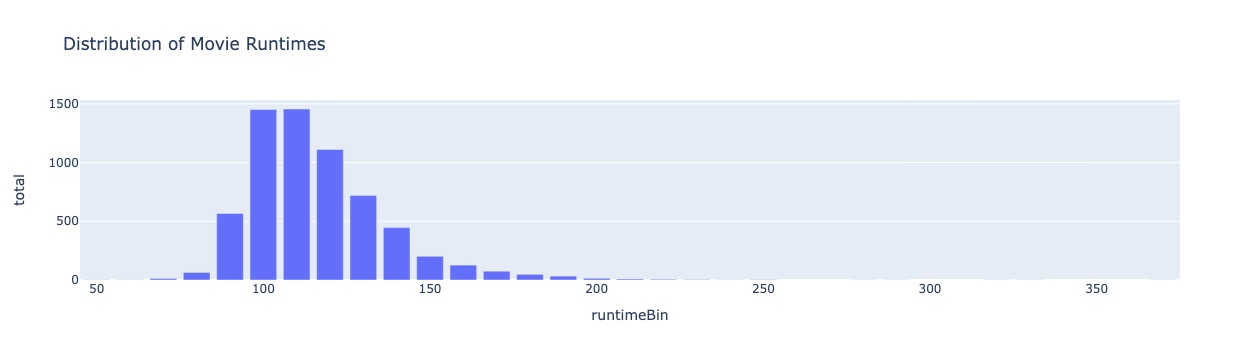

In [144]:
px.bar(res_q4, x="runtimeBin", y="total", title="Distribution of Movie Runtimes")

<!-- BEGIN QUESTION -->

<br><br>

---

### Average Number of Votes vs Average Rating for Each Movie Bucket

Let's visualize the information regarding the average number of votes and average ratings for each movie bucket. The first line graph shows the relationship between the number of votes vs runtime; and the second shows the relationship between average rating and runtime. We can see a clear correlation, which might explain why directors keep going with a particular range of runtimes. 

<AxesSubplot:xlabel='runtimeBin', ylabel='averageRating'>

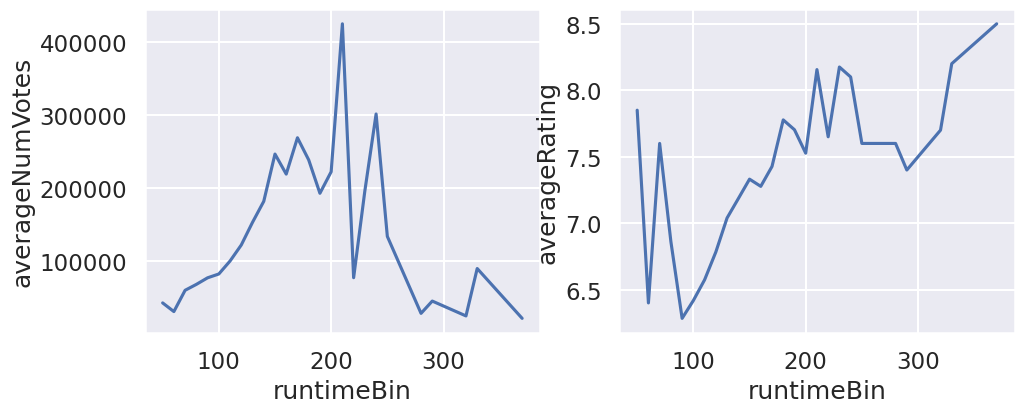

In [145]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1) # DO NOT MODIFY THIS LINE
sns.lineplot(data=res_q4, x='runtimeBin', y='averageNumVotes')
plt.subplot(1, 2, 2) # DO NOT MODIFY THIS LINE
sns.lineplot(data=res_q4, x='runtimeBin', y='averageRating')

<!-- END QUESTION -->

<br/><br/>

---

## Movie Actors With the Highest Average Rating

I use the following formula to calculate the top 10 actor's by average rating by taaking the sum of all of their ratings and dividing it by the number of votes. 
$$
\text{actorRating} = 
\frac{\sum_m \text{averageRating}[m] * \text{numVotes}[m]}{\sum_m \text{numVotes}[m]}
$$

Since this formula can be very skewed where some actors don't have a lot of ratings, I pick actors atht have  **at least 1000** votes and only consider and **at least 20 rated performances**. 

In [150]:
query_q5 = """
SELECT primaryName as name, 
SUM(Rating.averageRating * Rating.numVotes)/SUM(Rating.numVotes) AS actorRating
FROM Role

INNER JOIN Title ON Role.tconst = Title.tconst  
INNER JOIN Name ON Role.nconst = Name.nconst
INNER JOIN Rating ON Title.tconst = Rating.tconst

WHERE titleType IS 'movie' AND CAST(numVotes AS int) >= 1000 AND (category IS 'actor' OR category IS 'actress')
GROUP BY name HAVING COUNT(*) >= 20
ORDER BY actorRating DESC, name ASC
LIMIT 10;
"""


res_q5 = pd.read_sql(query_q5, engine)
res_q5

,name,actorRating
0,Diane Keaton,8.441302
1,Tim Robbins,8.247318
2,Al Pacino,8.138361
3,Michael Caine,8.133915
4,Leonardo DiCaprio,8.034961
5,Christian Bale,7.989825
6,Robert Duvall,7.946483
7,Jack Nicholson,7.933034
8,Kevin Spacey,7.926158
9,Clint Eastwood,7.866839
